# 1. Importing Libraries

In [50]:
import numpy as np 
import pandas as pd 
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure
from tensorflow.keras import layers, models

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

# 2. Data Preparation

In [52]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

for dirname, _, filenames in os.walk('../input/liver-tumor-segmentation-part-2'):
    for filename in filenames:
        file_list.append((dirname, filename)) 

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)   

,dirname,filename
89,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
81,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
142,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
31,../input/liver-tumor-segmentation/segmentations,segmentation-100.nii
45,../input/liver-tumor-segmentation/segmentations,segmentation-101.nii
...,...,...
166,../input/liver-tumor-segmentation/volume_pt5,volume-50.nii
27,../input/liver-tumor-segmentation/volume_pt1,volume-6.nii
30,../input/liver-tumor-segmentation/volume_pt1,volume-7.nii
21,../input/liver-tumor-segmentation/volume_pt1,volume-8.nii


In [54]:
# Map CT scan and label 


df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "../input/liver-tumor-segmentation/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,../input/liver-tumor-segmentation/volume_pt1,volume-0.nii,../input/liver-tumor-segmentation/segmentations,segmentation-0.nii
1,../input/liver-tumor-segmentation/volume_pt1,volume-1.nii,../input/liver-tumor-segmentation/segmentations,segmentation-1.nii
2,../input/liver-tumor-segmentation/volume_pt1,volume-10.nii,../input/liver-tumor-segmentation/segmentations,segmentation-10.nii
3,../input/liver-tumor-segmentation/volume_pt2,volume-11.nii,../input/liver-tumor-segmentation/segmentations,segmentation-11.nii
4,../input/liver-tumor-segmentation/volume_pt2,volume-12.nii,../input/liver-tumor-segmentation/segmentations,segmentation-12.nii
5,../input/liver-tumor-segmentation/volume_pt2,volume-13.nii,../input/liver-tumor-segmentation/segmentations,segmentation-13.nii
6,../input/liver-tumor-segmentation/volume_pt2,volume-14.nii,../input/liver-tumor-segmentation/segmentations,segmentation-14.nii
7,../input/liver-tumor-segmentation/volume_pt2,volume-15.nii,../input/liver-tumor-segmentation/segmentations,segmentation-15.nii
8,../input/liver-tumor-segmentation/volume_pt2,volume-16.nii,../input/liver-tumor-segmentation/segmentations,segmentation-16.nii
9,../input/liver-tumor-segmentation/volume_pt2,volume-17.nii,../input/liver-tumor-segmentation/segmentations,segmentation-17.nii


# 3. Data Preprocessing

In [56]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [58]:
# Read sample

sample = 40
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 74)
Mask Shape: (512, 512, 74)


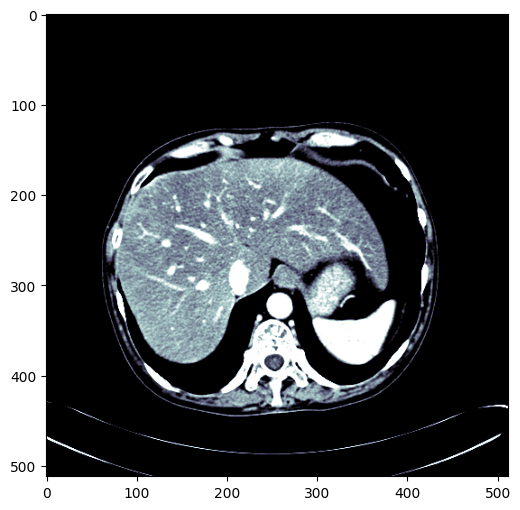

In [60]:
# Preprocess the nii file 
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

# Data Visualization
## Display Sample Images

In [62]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

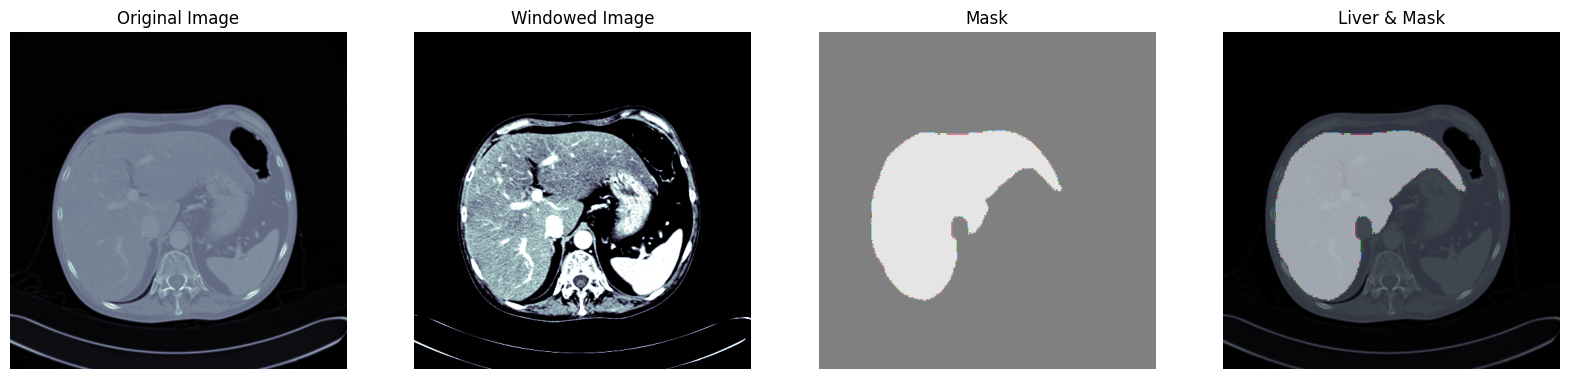

In [64]:
sample = 45

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<Axes: >

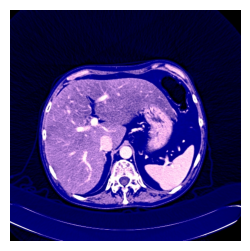

In [66]:
# Preprocessing functions
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'} #a subclass of a PyTorch Tensor designed to handle black-and-white images.

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120): #unction to convert the tensor to a multi-channel image suitable for saving as a JPG.The image is saved with the specified quality.
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

# 4. Generate Training Image From 'nii' File

In [68]:
from sklearn.model_selection import train_test_split

GENERATE_JPG_FILES = True

if GENERATE_JPG_FILES:

    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)

    ## test folder
    os.makedirs('test_images', exist_ok=True)
    os.makedirs('test_masks', exist_ok=True)

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df_files, test_size=0.1, random_state=42)

    # Check if train_df is empty
    print("Length of train_df:", len(train_df))

    # Reset index for contiguous indices
    train_df = train_df.reset_index(drop=True)
    # Check if test_df is empty
    print("Length of test_df:", len(test_df))
    test_df = test_df.reset_index(drop=True)

    # Loop for training set
    for ii in tqdm(range(len(train_df))):
        curr_ct = read_nii(train_df.loc[ii, 'dirname'] + "/" + train_df.loc[ii, 'filename'])
        curr_mask = read_nii(train_df.loc[ii, 'mask_dirname'] + "/" + train_df.loc[ii, 'mask_filename'])
        curr_file_name = str(train_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

    ### test image save
    for ii in tqdm(range(len(test_df))):
        curr_ct = read_nii(test_df.loc[ii, 'dirname'] + "/" + test_df.loc[ii, 'filename'])
        curr_mask = read_nii(test_df.loc[ii, 'mask_dirname'] + "/" + test_df.loc[ii, 'mask_filename'])
        curr_file_name = str(test_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"test_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output

Length of train_df: 45
Length of test_df: 6


  0%|          | 0/45 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


  0%|          | 0/6 [00:00<?, ?it/s]

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


## 4.1 - Check Data

In [70]:
print("\nFirst few rows of Training Set:")
print(train_df.head())

print("\nFirst few rows of Testing Set:")
print(test_df.head())


First few rows of Training Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segmentation/volume_pt3  volume-24.nii   
1  ../input/liver-tumor-segmentation/volume_pt4  volume-38.nii   
2  ../input/liver-tumor-segmentation/volume_pt2  volume-11.nii   
3  ../input/liver-tumor-segmentation/volume_pt4  volume-36.nii   
4  ../input/liver-tumor-segmentation/volume_pt2  volume-20.nii   

                                      mask_dirname        mask_filename  
0  ../input/liver-tumor-segmentation/segmentations  segmentation-24.nii  
1  ../input/liver-tumor-segmentation/segmentations  segmentation-38.nii  
2  ../input/liver-tumor-segmentation/segmentations  segmentation-11.nii  
3  ../input/liver-tumor-segmentation/segmentations  segmentation-36.nii  
4  ../input/liver-tumor-segmentation/segmentations  segmentation-20.nii  

First few rows of Testing Set:
                                        dirname       filename  \
0  ../input/liver-tumor-segm

In [72]:
print("\ntrain df data shape:")
print(train_df.shape)


train df data shape:
(45, 4)


In [74]:
print("\ntest df data shape:")
print(test_df.shape)


test df data shape:
(6, 4)


# 5. Resizing Images

In [76]:
# Set the directories
train_images_dir = '/kaggle/working/train_images'
train_masks_dir = '/kaggle/working/train_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(train_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing nd converted to numpy arrays
target_size = (128, 128)
train_images = [np.array(Image.open(os.path.join(train_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks 
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
train_masks = [np.array(Image.open(os.path.join(train_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays  for further processing
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Normalize images to [0, 1]
train_images =train_images / 255.0

# Reshape masks to include a channel dimension
train_masks =train_masks.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], 1))

In [78]:
# Set the directories
test_images_dir = '/kaggle/working/test_images'
test_masks_dir = '/kaggle/working/test_masks'

# Get the list of image file names
all_image_file_names = sorted(os.listdir(test_images_dir))

# Determine the sample size
sample_size = min(9000, len(all_image_file_names))

# Randomly select images
selected_image_file_names = random.sample(all_image_file_names, sample_size)

# Load selected images and masks with resizing
target_size = (128, 128)
test_images = [np.array(Image.open(os.path.join(test_images_dir, fname)).resize
                        (target_size)) for fname in selected_image_file_names]

# Adjust file extension for masks
mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
test_masks = [np.array(Image.open(os.path.join(test_masks_dir, fname)).resize
                       (target_size)) for fname in mask_file_names]

# Convert the lists to numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Normalize images to [0, 1]
test_images =test_images / 255.0

# Reshape masks to include a channel dimension
test_masks =test_masks.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 1))

In [80]:
print(f"Train image ={len(train_images)} Test image={len(test_images)}")
print(f"Train mask ={len(train_masks)}  Test mask={len(test_masks)}")

Train image =8556 Test image=699
Train mask =8556  Test mask=699


# 6. Spliting Data Train Test and Validation

In [82]:
x_valid, x_test, y_valid, y_test = train_test_split(test_images, test_masks, test_size=1/3, random_state=42)

In [84]:
print(f"train image={train_images.shape} and train_masks={train_masks.shape}")
print(f"X valid shape ={x_valid.shape} x_test={x_test.shape}")
print(f"y valid shape ={y_valid.shape}  y_test={y_test.shape}")

train image=(8556, 128, 128, 3) and train_masks=(8556, 128, 128, 1)
X valid shape =(466, 128, 128, 3) x_test=(233, 128, 128, 3)
y valid shape =(466, 128, 128, 1)  y_test=(233, 128, 128, 1)


## 6.2  Display Random Images and Masks

In [86]:
def display_images_and_masks(images, masks, num_samples=2):
    # Randomly select 'num_samples' number of indices from the available images.
    sample_indices = random.sample(range(images.shape[0]), num_samples)
    
    # Loop through each sample.
    for i in range(num_samples):
        index = sample_indices[i]  # Get the index of the current sample.
        
        #  Display the image.
        plt.subplot(num_samples, 2, 2 * i + 1)  # Prepare a subplot.
        plt.imshow(images[index])  # Show the image at the selected index.
        plt.title("Image {}".format(index))  # Set the title for the image.
        plt.axis("off")  # Turn off the axis.
        
        #  Display the corresponding mask.
        plt.subplot(num_samples, 2, 2 * i + 2)  # Prepare the next subplot.
        plt.imshow(masks[index].squeeze(), cmap='gray')  # Show the mask with a grayscale colormap.
        plt.title("Mask {}".format(index))  # Set the title for the mask.
        plt.axis("off")  # Turn off the axis.
    
    # Display all the subplots.
    plt.show()

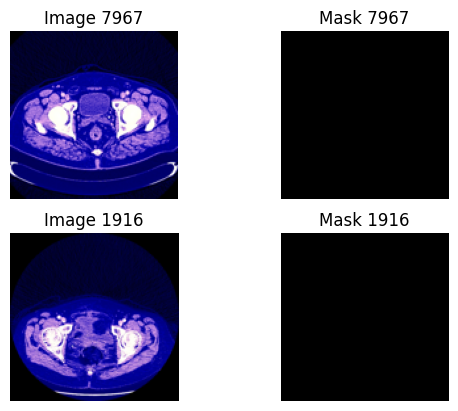

In [88]:
# Display two random images and masks
display_images_and_masks(train_images, train_masks)

# 7. Model Training

## 7.1 - ResNet50 Model

In [90]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D

In [92]:
def build_model(input_shape=(128, 128, 3), num_classes=1, weights_path=None):
    # Load the ResNet50 model with the option to load pre-trained weights and excluding the top (fully connected) layers.
    base_model = ResNet50(include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the layers of the base model to prevent them from being updated during training.
    for layer in base_model.layers:
        layer.trainable = False

    # Start building the custom layers on top of the base model's output.
    x = base_model.output

    # Begin upsampling and adding convolutional layers to build the segmentation head.
    x = UpSampling2D((2, 2))(x)  # Upsample the feature map to increase its spatial dimensions.
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Add a convolutional layer with 512 filters.
    x = UpSampling2D((2, 2))(x)  # Continue upsampling.
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Add another convolutional layer with 256 filters.
    x = UpSampling2D((2, 2))(x)  # And so on...
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Add the final convolutional layer with a filter for each class (in this case, binary, so only 1 filter).
    x = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Create the model object by specifying the inputs and outputs.
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model with an optimizer, loss function, and metrics to monitor.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Return the compiled model.
    return model

In [94]:
#calling the build_model function to create a new model based on the ResNet50 architecture
model = build_model()

## 7.2 Train the Model

*'train_images' are the input images for training.*

*train_masks' are the corresponding ground truth masks for the input images.*

*'batch_size' is set to 32, meaning the model will update weights after every 32 samples.*

*'epochs' is set to 10, meaning the model will go through the entire dataset 10 times.* 

*'validation_data' is a tuple containing the validation dataset and its corresponding masks.*

*The model's performance is evaluated on this validation dataset after each epoch.*
poch.

In [96]:
history = model.fit(train_images, train_masks, batch_size=32, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9787 - loss: 0.0856 - val_accuracy: 0.9804 - val_loss: 0.0511
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9849 - loss: 0.0350 - val_accuracy: 0.9635 - val_loss: 0.0720
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9835 - loss: 0.0391 - val_accuracy: 0.9849 - val_loss: 0.0415
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9861 - loss: 0.0321 - val_accuracy: 0.9817 - val_loss: 0.0493
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9823 - loss: 0.0423 - val_accuracy: 0.9825 - val_loss: 0.0486
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9879 - loss: 0.0299 - val_accuracy: 0.9867 - val_loss: 0.0350
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9895 - loss: 0.0239 - val_accuracy: 0.9864 - val_loss: 0.0367
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.9903 - loss: 0.0211 - 

In [98]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['loss'])
    # Plot the validation loss values
    plt.plot(history.history['val_loss'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

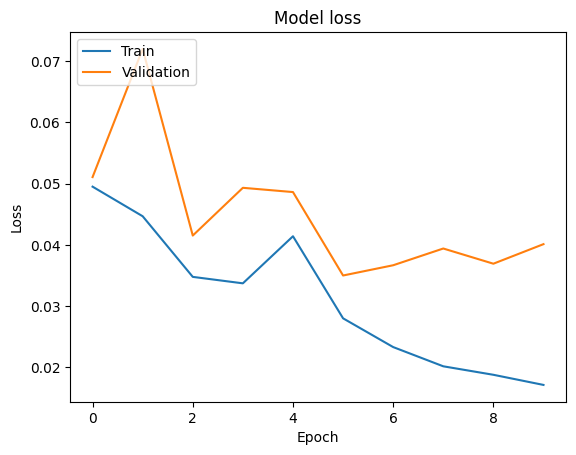

In [100]:
# Plotting the loss curve
plot_history(history)

In [102]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['accuracy'])
    # Plot the validation loss values
    plt.plot(history.history['val_accuracy'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

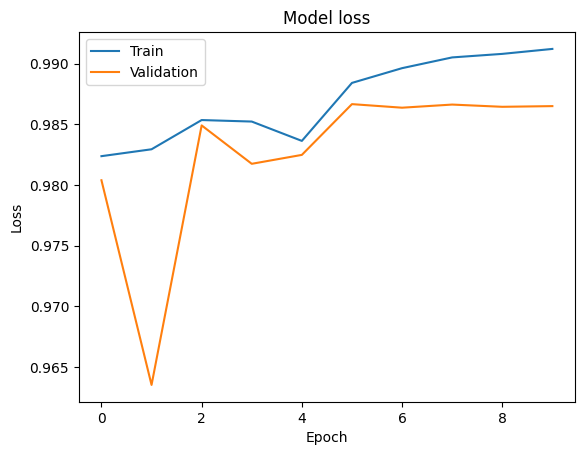

In [104]:
# Plotting the accuracy curve
plot_history(history)

# 8. Model Evaluation

In [106]:
# Evaluate the model using the validation dataset.
# 'x_valid' are the input images for validation.
# 'y_valid' are the corresponding ground truth masks for the validation images.
scores = model.evaluate(x_valid, y_valid)

# 'scores' is a list containing the loss as the first element and the accuracy as the second element.
# By accessing 'scores[1]', we retrieve the accuracy of the model on the validation dataset.
accuracy = scores[1]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9860 - loss: 0.0423


In [108]:
print("Validation Accuracy: ", accuracy)

Validation Accuracy:  0.9864978790283203


In [110]:
prediction = model.predict(x_test)# Use the trained model to make predictions on the test dataset.

# 'x_test' contains the input images for testing.
prediction = model.predict(x_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [112]:
# Evaluate the model using the test data (x_test, y_test)
test_scores = model.evaluate(x_test, y_test)

# test_scores is a list that contains the loss as the first element and the accuracy as the second element.
# Here, we are accessing the second element, which is the accuracy of the model on the test data.
accuracy = test_scores[1]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9873 - loss: 0.0382


In [114]:
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9877232909202576


# 9. Making Final Prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


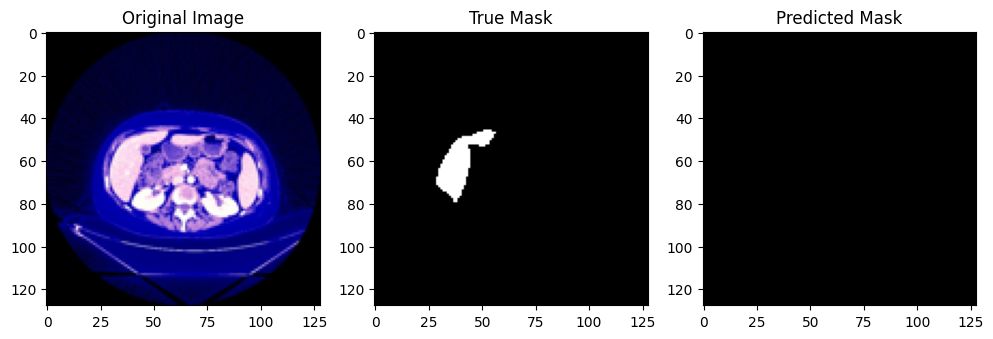

In [116]:
image_index = 58

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Obtain the predicted mask from model2
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]

# Threshold the predicted mask (assuming it's a binary mask)
threshold = 0.5  # Adjust this threshold based on your model's output
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting
plt.figure(figsize=(12, 4))

# Plot original image
plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

# Plot true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

# Plot predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary, cmap='gray')
plt.title('Predicted Mask')

plt.show()

# 10. U-Net Model

In [118]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the U-Net model architecture with detailed comments
def unet_model(input_layer):
    # Encoder
    # First convolutional block with 64 filters and relu activation, same padding keeps dimensions unchanged
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    # First pooling layer reduces spatial dimensions by half (downsampling)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second convolutional block with 128 filters, following the downsampling
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    # Second pooling layer continues to reduce dimensions
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder
    # Third convolutional block, placed in the decoder part with upsampling coming next
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    # Upsampling layer to increase the spatial dimensions to match those of conv2
    up1 = UpSampling2D((2, 2))(conv3)
    # Concatenation layer merges feature maps from encoder (conv2) with upsampled maps, crucial for U-Net architecture
    concat1 = concatenate([conv2, up1], axis=-1)
    
    # Fourth convolutional block after concatenation to refine features
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    # Final upsampling to increase the dimensions to match those of conv1
    up2 = UpSampling2D((2, 2))(conv4)
    # Final concatenation with the very first convolutional layer outputs
    concat2 = concatenate([conv1, up2], axis=-1)
    
    # Output layer with a single filter and sigmoid activation to produce a binary segmentation map
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)
    
    # Create the model instance with specified inputs and outputs
    model = Model(inputs=input_layer, outputs=outputs)
    return model

# Instantiate the U-Net model specifying the input shape
input_layer = Input(shape=(128, 128, 3), name='input_layer_1')
unet_model = unet_model(input_layer)

# Compile the model specifying optimizer, loss function, and metrics for evaluation
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the U-Net model on the provided training data, also include validation data for evaluating performance
unet_model.fit(train_images, train_masks, batch_size=32, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9757 - loss: 0.2577 - val_accuracy: 0.9838 - val_loss: 0.0426
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9855 - loss: 0.0398 - val_accuracy: 0.9852 - val_loss: 0.0361
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9871 - loss: 0.0334 - val_accuracy: 0.9858 - val_loss: 0.0347
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9876 - loss: 0.0311 - val_accuracy: 0.9854 - val_loss: 0.0343
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9878 - loss: 0.0302 - val_accuracy: 0.9869 - val_loss: 0.0323


In [120]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['loss'])
    # Plot the validation loss values
    plt.plot(history.history['val_loss'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

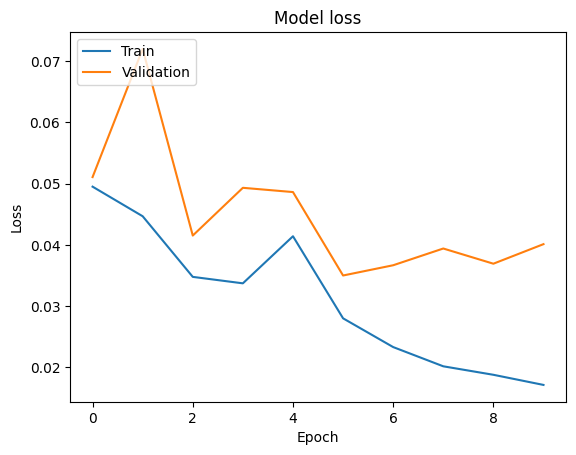

In [122]:
# Plotting the loss curve
plot_history(history)

In [124]:
def plot_history(history):
    # Plot the training loss values
    plt.plot(history.history['accuracy'])
    # Plot the validation loss values
    plt.plot(history.history['val_accuracy'])
    # Set the title of the plot to 'Model loss'
    plt.title('Model loss')
    # Set the y-axis label of the plot to 'Loss'
    plt.ylabel('Loss')
    # Set the x-axis label of the plot to 'Epoch'
    plt.xlabel('Epoch')
    # Add a legend to the plot with labels 'Train' for training loss and 'Validation' for validation loss
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Display the plot
    plt.show()

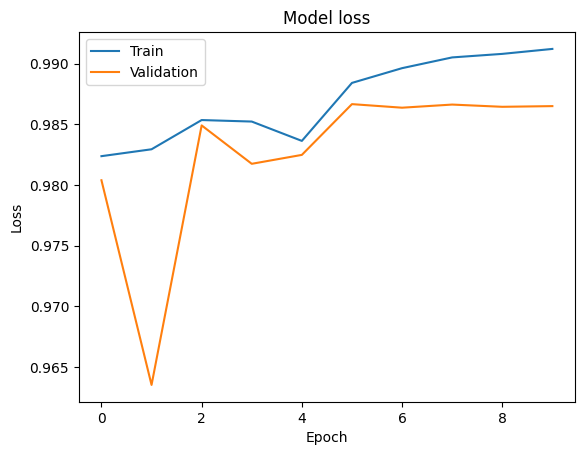

In [126]:
# Plotting the accuracy curve
plot_history(history)

## 10.2 Evaluating U-Net Model

In [128]:
# Evaluate the performance of the trained U-Net model on the test dataset
evaluation = unet_model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9871 - loss: 0.0326


In [130]:
accuracy = evaluation[1]

In [131]:
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.9873405694961548


## 10.3 Making Prediction with U-Net Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


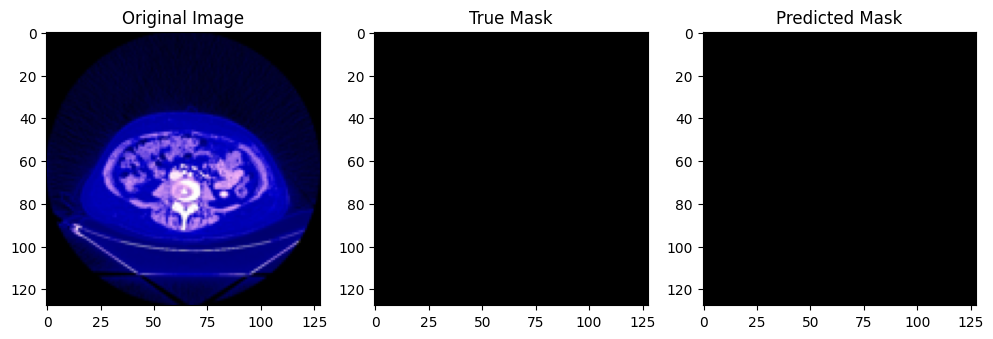

In [132]:
# Import the numpy library for numerical operations and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt

# Select an index for the image to be visualized and analyzed
image_index = 55

# Load the image and corresponding true mask from the test dataset
input_image = x_test[image_index]  # The input image to the model
true_mask = y_test[image_index]    # The ground truth mask for the input image

# Obtain the predicted mask from the U-Net model
predicted_mask = unet_model.predict(np.expand_dims(input_image, axis=0))[0]  # Model prediction for the input image

# Apply a threshold to convert the predicted mask to a binary mask
threshold = 0.5  
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)  # Binary version of the predicted mask

# Set up the plotting environment with a figure size
plt.figure(figsize=(12, 4))

# Plot the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(input_image)  # Display the original image
plt.title('Original Image')  # Title for the first subplot

# Plot the true mask in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')  # Display the true mask in grayscale
plt.title('True Mask')  # Title for the second subplot

# Plot the predicted binary mask in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')  # Display the binary predicted mask in grayscale
plt.title('Predicted Mask')  # Title for the third subplot

# Display the plots
plt.show()

## 11. Proposed CAPSNET-SA model 

## Define Capsule Network with Self-Attention

Train images = 8556, Test images = 699
Train masks = 8556, Test masks = 699
Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9801 - loss: 0.0868 - val_accuracy: 0.9839 - val_loss: 0.0387
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9852 - loss: 0.0376 - val_accuracy: 0.9856 - val_loss: 0.0343
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9871 - loss: 0.0311 - val_accuracy: 0.9859 - val_loss: 0.0338
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9876 - loss: 0.0285 - val_accuracy: 0.9866 - val_loss: 0.0317
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9886 - loss: 0.0259 - val_accuracy: 0.9870 - val_loss: 0.0334
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9889 - loss: 0.0244 - val_accuracy: 0.9879 - val_loss: 0.0286
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9895 - loss: 0.0218 - val_accuracy: 0.9875 - val_loss: 0.0299
Epoch 8/10
535

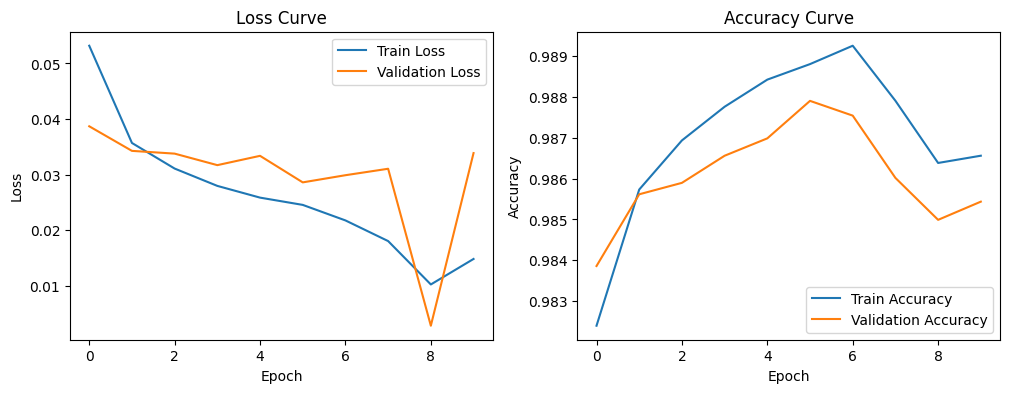

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


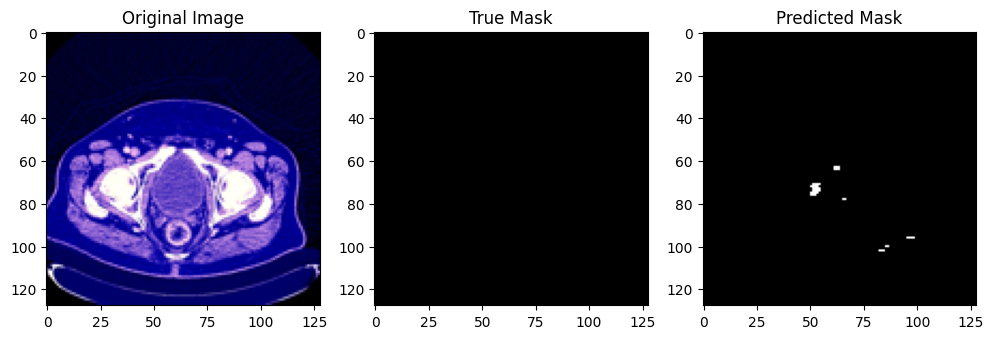

In [133]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Print dataset details
print(f"Train images = {len(train_images)}, Test images = {len(test_images)}")
print(f"Train masks = {len(train_masks)}, Test masks = {len(test_masks)}")

# Function to Build CapsNet with Self-Attention
def build_capsnet_with_attention(input_shape=(128, 128, 3), num_classes=1):
    inputs = keras.Input(shape=input_shape)

    # Convolutional Base (Feature Extractor)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)  # 64x64x128

    # Primary Capsules
    primary_caps = layers.Conv2D(16 * 8, (3, 3), strides=2, padding="same")(x)  # 32x32x128
    primary_caps = layers.Reshape((-1, 8))(primary_caps)  # Reshape into Capsules

    # Self-Attention Mechanism
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=8)(primary_caps, primary_caps)
    attention = layers.Add()([primary_caps, attention])
    attention = layers.LayerNormalization()(attention)

    # Decoder (Segmentation Head) - Ensure final shape is (128, 128, num_classes)
    decoder = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x)  # 64x64x128
    decoder = layers.UpSampling2D((2, 2))(decoder)  # 128x128x128
    decoder = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(decoder)  # 128x128x64
    decoder = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(decoder)  # 128x128x1 (Fixed Output)

    # Define Model
    model = Model(inputs, decoder)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

# Build and Train the Capsule Network with Self-Attention
capsnet_attention_model = build_capsnet_with_attention((128, 128, 3))

# Train the model with correct dataset split
history = capsnet_attention_model.fit(train_images, train_masks, batch_size=16, epochs=10, validation_data=(x_valid, y_valid))

# Save Model
capsnet_attention_model.save("capsnet_liver_segmentation.h5")
print("✅ CapsNet-SA training complete!")

# Evaluate Model on Test Set
test_loss, test_accuracy = capsnet_attention_model.evaluate(x_test, y_test)
print(f"🟢 Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Show Training Curves
plot_history(history)

# Model Prediction on a Test Image
image_index = 5  # Choose any test image index
input_image = x_test[image_index]
true_mask = y_test[image_index]

# Get Model Prediction
predicted_mask = capsnet_attention_model.predict(np.expand_dims(input_image, axis=0))[0]
predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)  # Apply threshold

# Plot Results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary[:, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()
